In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0);

In [ ]:
import imageio
import glob
emojis = []
for im_path in glob.glob("/content/drive/MyDrive/GAN Course/emojis/image/Apple/*.png"):
     im = imageio.imread(im_path)
     #print(im.shape)
     emojis.append(im)

In [ ]:
import torch
t= torch.tensor(emojis)

<ipython-input-3-523e2997ad83>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  t= torch.tensor(emojis)


In [ ]:
t.shape

torch.Size([1823, 72, 72, 4])

In [ ]:
torch.max(t[0,:,:,3])

tensor(255, dtype=torch.uint8)

In [ ]:
t.dtype

torch.uint8

CPU times: user 23.6 ms, sys: 955 µs, total: 24.5 ms
Wall time: 31.2 ms


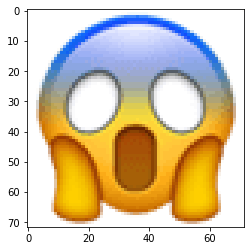

In [ ]:
%%time
import matplotlib.pyplot as plt
plt.imshow(t[800]);

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Smileys(Dataset):
  def __init__(self):
    emojis = []
    for im_path in glob.glob("/content/drive/MyDrive/GAN Course/emojis/image/Apple/*.png"):
        im = imageio.imread(im_path)
        #print(im.shape)
        emojis.append(im)
    self.data= torch.Tensor(emojis) #crucial line
    self.labels = torch.ones(len(self.data),1)

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
dataset = Smileys()

In [ ]:
type(dataset)

__main__.Smileys

In [ ]:
len(dataset[800])

2

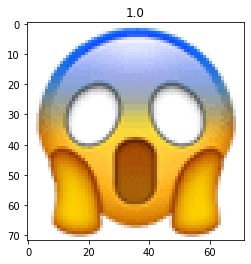

In [ ]:
plt.imshow(dataset[800][0]/255)
plt.title(dataset[800][1].item());


In [ ]:
# Load dataset as tensors
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True)

In [ ]:
example=next(iter(dataloader))

In [ ]:
example[1]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [ ]:
example[0][0]

tensor([[[ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         ...,
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.]],

        [[ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         ...,
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.]],

        [[ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         ...,
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.]],

        ...,

        [[ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         ...,
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.]],

        [[ 71., 112.,  76.,   0.],
         [ 71., 112.,  76.,   0.],
         [ 7

Text(0.5, 1.0, '1.0')

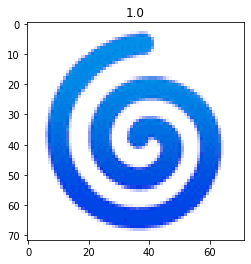

In [ ]:
plt.imshow(example[0][0]/255)
plt.title(example[1][0].item())

## Model!

In [ ]:
def build_generator_layer(input_dim, output_dim):
    '''
    Function for returning a layer of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a ReLU activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        )

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (Smiley images are 72 x 72 x 4 =  so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=72* 72* 4, hidden_dim=128):
        super().__init__()
        # Build the neural network
        self.generator_model = nn.Sequential(
            build_generator_layer(z_dim, hidden_dim), # Layer 1
            build_generator_layer(hidden_dim, hidden_dim * 2), # Layer 2
            build_generator_layer(hidden_dim * 2, hidden_dim * 4), # Layer 3
            build_generator_layer(hidden_dim * 4, hidden_dim * 8), # Layer 4
            nn.Linear(hidden_dim * 8, im_dim), # First part of layer 5 (layer 5 is also the output layer)
            nn.Sigmoid(), # Second part of layer 5 (layer 5 is also the output layer)
            )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        output_vector= self.generator_model(noise)
        return output_vector
    

In [ ]:
def build_noise_input_vetors(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    
    return torch.randn(n_samples, z_dim, device=device)
    

In [ ]:
noise=build_noise_input_vetors(32, 10, device='cpu')
noise.shape

torch.Size([32, 10])

In [ ]:
g=Generator()
g_out=g(noise)
g_out.shape

torch.Size([32, 20736])

In [ ]:
72*72*4

20736

In [ ]:
def build_discriminator_layer(input_dim, output_dim):
    '''
    Function for returning a layer of the discriminator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
        )

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=72*72*4, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.discriminator_model = nn.Sequential(
            build_discriminator_layer(im_dim, hidden_dim * 4), # Layer 1
            build_discriminator_layer(hidden_dim * 4, hidden_dim * 2), # Layer 2
            build_discriminator_layer(hidden_dim * 2, hidden_dim), # Layer 3
            nn.Linear(hidden_dim,1) # Layer 4 (layer 4 is also the output layer)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.discriminator_model(image)

In [ ]:
d= Discriminator()
d_out= d(g_out)
d_out

tensor([[0.0150],
        [0.0168],
        [0.0122],
        [0.0175],
        [0.0145],
        [0.0142],
        [0.0106],
        [0.0106],
        [0.0215],
        [0.0213],
        [0.0166],
        [0.0224],
        [0.0186],
        [0.0178],
        [0.0183],
        [0.0153],
        [0.0199],
        [0.0213],
        [0.0153],
        [0.0190],
        [0.0163],
        [0.0177],
        [0.0168],
        [0.0212],
        [0.0173],
        [0.0166],
        [0.0174],
        [0.0169],
        [0.0214],
        [0.0145],
        [0.0179],
        [0.0116]], grad_fn=<AddmmBackward0>)

In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 500
z_dim = 64 #length of the noise vector
display_step = 500
lr = 0.00001


# check if CUDA is available
# this is a standard code for checking which device is avaible in saving it as the default device for later use
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [ ]:
gen = Generator(z_dim).to(device) # build a Generator Model from the Generator class
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr) # define an Adam optimizer for the Generator
disc = Discriminator().to(device) # build a Discriminator Model from the Discriminator class
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr) # define an Adam optimizer for the Discriminator

In [ ]:
def compute_discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''

    noise = build_noise_input_vetors(num_images, z_dim, device=device) #  Create noise vectors   
    fake_images = gen(noise) # generate a batch (num_images) of fake images.
    disc_fake_pred = disc(fake_images.detach()) # Get the discriminator's prediction of the fake images
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # calculate the loss - the labels are all zero (i.e. fake) so we can just build them in the loss function
    disc_real_pred = disc(real) # Get the discriminator's prediction of the real images
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # calculate the loss - the labels are all one (i.e. real) so we can just build them in the loss function
    disc_loss = (disc_fake_loss + disc_real_loss) / 2 # Calculate the discriminator's loss by averaging the real and fake loss and set it to disc_loss.
    
    return disc_loss

In [ ]:
def compute_generator_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    
    noise = build_noise_input_vetors(num_images, z_dim, device=device) # Create noise vectors 
    fake_images = gen(noise) # generate a batch of fake images
    disc_fake_pred = disc(fake_images) # Get the discriminator's prediction of the fake images
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) # Calculate the generator's loss - the generator wants the discriminator to think that its fake images are real i.e. the labels have to be one

    return gen_loss

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(72, 72, 4)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_unflat = image_unflat.permute(0, 3, 1, 2)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8, step 500: Generator loss: 0.40579468047618844, discriminator loss: 0.5511960946321486


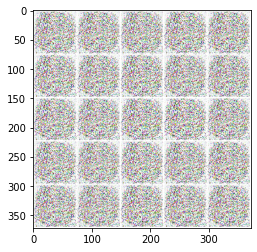

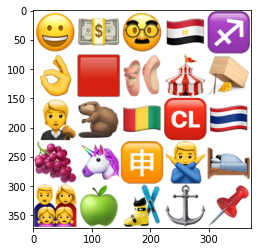

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17, step 1000: Generator loss: 0.4053375697731972, discriminator loss: 0.549585065245629


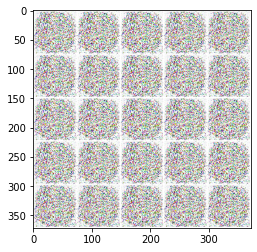

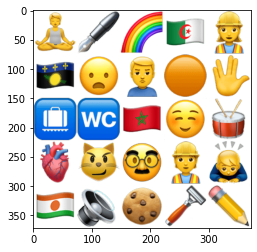

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 26, step 1500: Generator loss: 0.4054509115815163, discriminator loss: 0.5494232434034348


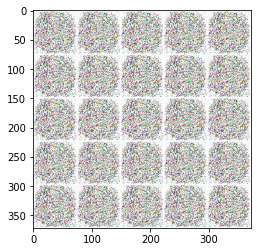

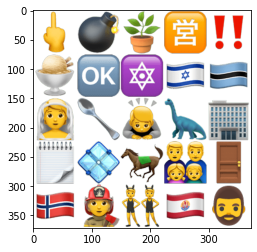

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 35, step 2000: Generator loss: 0.40544298970699294, discriminator loss: 0.5493740783929822


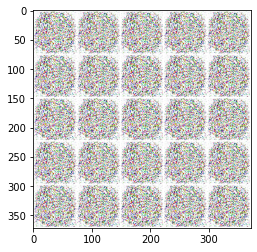

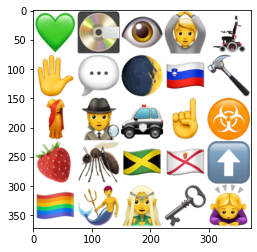

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 43, step 2500: Generator loss: 0.4054761691689489, discriminator loss: 0.5493285614252095


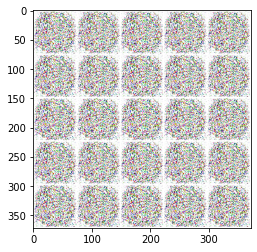

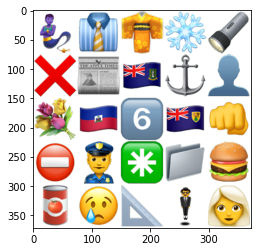

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 52, step 3000: Generator loss: 0.40546816372871386, discriminator loss: 0.5493223016262059


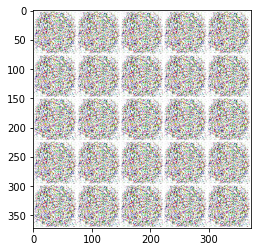

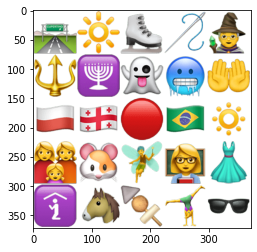

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False

##Training starts here!!!
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        
        # Calculate discriminator loss
        disc_loss = compute_discriminator_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # Zero out the gradients for the next pass
        disc_opt.zero_grad()


        ### Update generator ###
        
        gen_loss = compute_generator_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        gen_opt.zero_grad()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = build_noise_input_vetors(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real/255)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
